# Phase Estimation of Quantum Walks

## Heisenberg limited phase estimation
Implements Heisenberg-Limited Phase Estimation of the Qubitized Quantum Walks as described in Section-II B. of [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662)

In [11]:
import cirq
import numpy as np

from qualtran._infra.gate_with_registers import get_named_qubits
from qualtran.bloqs.qubitization import QubitizationWalkOperator
from qualtran.bloqs.qubitization.qubitization_walk_operator_test import get_walk_operator_for_1d_ising_model
from qualtran.bloqs.chemistry.hubbard_model.qubitization import get_walk_operator_for_hubbard_model

### Phase estimation circuit

We start by quickly sketching the phase estimation circuit in terms of the walk operator.

In [12]:
def get_resource_state(m: int):
    r"""Returns a state vector representing the resource state on m qubits from Eq.17 of Ref-1.
    
    Returns a numpy array of size 2^{m} representing the state vector corresponding to the state
    $$
        \sqrt{\frac{2}{2^m + 1}} \sum_{n=0}^{2^{m}-1} \sin{\frac{\pi(n + 1)}{2^{m}+1}}\ket{n}
    $$
    
    Args:
        m: Number of qubits to prepare the resource state on.
    
    Ref:
        1) [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity]
            (https://arxiv.org/abs/1805.03662)
            Eq. 17
    """
    den = 1 + 2 ** m
    norm = np.sqrt(2 / den)
    return norm * np.sin(np.pi * (1 + np.arange(2**m)) / den)        
    
def phase_estimation(walk: QubitizationWalkOperator, m: int) -> cirq.OP_TREE:
    """Heisenberg limited phase estimation circuit for learning eigenphase of `walk`.
    
    The method yields an OPTREE to construct Heisenberg limited phase estimation circuit 
    for learning eigenphases of the `walk` operator with `m` bits of accuracy. The 
    circuit is implemented as given in Fig.2 of Ref-1.
    
    Args:
        walk: Qubitization walk operator.
        m: Number of bits of accuracy for phase estimation. 
        
    Ref:
        1) [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity]
            (https://arxiv.org/abs/1805.03662)
            Fig. 2
    """
    reflect = walk.reflect
    walk_regs = get_named_qubits(walk.signature)
    reflect_regs = {reg.name: walk_regs[reg.name] for reg in reflect.signature}
    
    reflect_controlled = reflect.controlled(control_values=[0])
    walk_controlled = walk.controlled(control_values=[1])

    m_qubits = [cirq.q(f'm_{i}') for i in range(m)]
    state_prep = cirq.StatePreparationChannel(get_resource_state(m), name='chi_m')

    yield state_prep.on(*m_qubits)
    yield walk_controlled.on_registers(**walk_regs, ctrl=m_qubits[0])
    for i in range(1, m):
        yield reflect_controlled.on_registers(control=m_qubits[i], **reflect_regs)
        walk = walk ** 2
        yield walk.on_registers(**walk_regs)
        yield reflect_controlled.on_registers(control=m_qubits[i], **reflect_regs)
        
    yield cirq.qft(*m_qubits, inverse=True)

In [13]:
num_sites: int = 6
eps: float = 1e-2
m_bits: int = 4

walk_op, _ = get_walk_operator_for_1d_ising_model(num_sites, eps)
circuit = cirq.Circuit(phase_estimation(walk_op, m=m_bits))
print(circuit)

m_0: ──────────chi_m[1]───@───────────────────────────────────────────────────────────────qft^-1───
               │          │                                                               │
m_1: ──────────chi_m[2]───┼───@(0)─────────@(0)───────────────────────────────────────────#2───────
               │          │   │            │                                              │
m_2: ──────────chi_m[3]───┼───┼────────────┼──────@(0)─────────@(0)───────────────────────#3───────
               │          │   │            │      │            │                          │
m_3: ──────────chi_m[4]───┼───┼────────────┼──────┼────────────┼──────@(0)─────────@(0)───#4───────
                          │   │            │      │            │      │            │
selection0: ──────────────W───R_L────W^2───R_L────R_L────W^4───R_L────R_L────W^8───R_L─────────────
                          │   │      │     │      │      │     │      │      │     │
selection1: ──────────────W───R_L────W^2───R_L────R_L─

### Computing costs

Usually, you'd define a Bloq that captures the entire phase estimation circuit, but we can use a little helper function to compute the gate counts directly from the bloqs encountered within the Cirq circuit.

In [14]:
from qualtran import Bloq
from qualtran.resource_counting import get_cost_value, QECGatesCost, GateCounts

def get_qec_gates_cost_for_circuit(circuit):
    # Usually, you'd combine this into a bloq of its own, but we
    # use this helper function to add up the costs of the bloqs
    # found within the circuit.
    cost_key = QECGatesCost()
    costs_cache = {}
    total_cost = cost_key.zero()
    for op in circuit.all_operations():
        if not isinstance(op.gate, Bloq):
            # Skip state prep and QFT for now
            continue
    
        bloq = op.gate
        total_cost += get_cost_value(bloq, cost_key, costs_cache=costs_cache)
    
    return total_cost

get_qec_gates_cost_for_circuit(circuit)

GateCounts(t=0, toffoli=0, cswap=168, and_bloq=1474, clifford=11825, rotation=84, measurement=1474)

## Resource estimates for 1D Ising model using generic SELECT / PREPARE 

In [15]:
from qualtran.cirq_interop.t_complexity_protocol import t_complexity_compat

num_sites: int = 200
eps: float = 1e-5
m_bits: int = 14

walk, _ = get_walk_operator_for_1d_ising_model(num_sites, eps)

circuit = cirq.Circuit(phase_estimation(walk, m=m_bits))
%time result = get_qec_gates_cost_for_circuit(circuit)
print(result)

CPU times: user 800 ms, sys: 12.3 ms, total: 813 ms
Wall time: 813 ms
cswap: 295362, and_bloq: 21321353, clifford: 124158198, rotation: 65636, measurement: 21321353


## Resource estimates for 2D Hubbard model using specialized SELECT / PREPARE 
Phase estimation of walk operator for 2D Hubbard Model using SELECT and PREPARE circuits from Section V of https://arxiv.org/abs/1805.03662

In [16]:
x_dim, y_dim = 20, 20
t = 20
mu = 4 * t
N = x_dim * y_dim * 2
qlambda = 2 * N * t + (N * mu) // 2
delta_E = t / 100
m_bits = int(np.ceil(np.log2(qlambda * np.pi * np.sqrt(2) / delta_E)))
walk = get_walk_operator_for_hubbard_model(x_dim, y_dim, t, mu)
circuit = cirq.Circuit(phase_estimation(walk, m=m_bits))
%time result = get_qec_gates_cost_for_circuit(circuit)
print(result)

CPU times: user 7.77 s, sys: 92.5 ms, total: 7.87 s
Wall time: 7.94 s
cswap: 134219344, and_bloq: 4391438157, clifford: 20696810140, rotation: 33555056, measurement: 4391438157


In [17]:
# Or, we can just use the included bloq example directly

from qualtran.bloqs.phase_estimation.qubitization_qpe import _qubitization_qpe_hubbard_model_large
qpe = _qubitization_qpe_hubbard_model_large.make()
%time result = get_cost_value(qpe, QECGatesCost())
print(result)

CPU times: user 7.76 s, sys: 118 ms, total: 7.88 s
Wall time: 7.96 s
t: 19, cswap: 134219344, and_bloq: 4391438389, clifford: 20696810716, rotation: 33555359, measurement: 4391438389


## Flame Graphs to visualize cost for QPE on Qubitized walk operator for 2D Hubbard model

T-count:   3.54214e+06
Rotations: 131428
Cliffords: 1.07402e+07



/Users/fionn/.venvs/qualtran/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


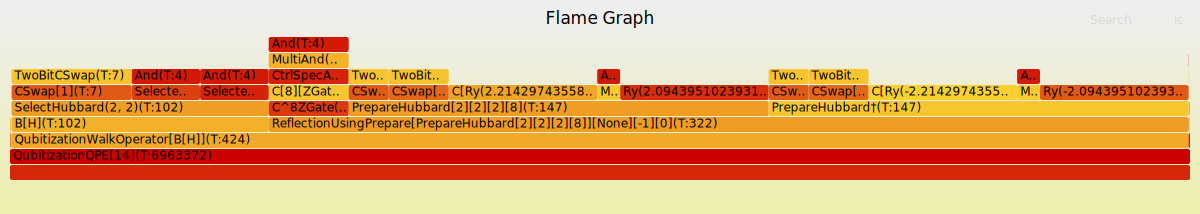

In [18]:
from qualtran.bloqs.phase_estimation.qubitization_qpe import _qubitization_qpe_hubbard_model_small
from qualtran.drawing import show_flame_graph

qpe_small = _qubitization_qpe_hubbard_model_small.make()
print(qpe_small.t_complexity())
show_flame_graph(qpe_small)

# Resource Estimates for THC Hamiltonian

Phase estimation of the Reiher THC hamiltonian from [https://arxiv.org/abs/2011.03494](https://arxiv.org/abs/2011.03494)

In [38]:
from qualtran.bloqs.chemistry.thc.walk_operator import get_reiher_thc_walk_operator
from qualtran.bloqs.phase_estimation import LPResourceState, QubitizationQPE
from qualtran.resource_counting.generalizers import generalize_cswap_approx

walk_op = get_reiher_thc_walk_operator()
%time result = get_cost_value(walk_op, QECGatesCost(), generalizer=generalize_cswap_approx).total_t_and_ccz_count(ts_per_rotation=0)['n_ccz']
print(f"{result=}")
algo_eps = 0.0016
qpe_eps = algo_eps / (walk_op.block_encoding.alpha * np.sqrt(2))
qpe = QubitizationQPE(
    walk, LPResourceState.from_standard_deviation_eps(qpe_eps)
)
%time result = get_cost_value(qpe, QECGatesCost(), generalizer=generalize_cswap_approx).total_t_and_ccz_count(ts_per_rotation=0)['n_ccz']
print(f"{result=:10.8e}")

CPU times: user 1.57 s, sys: 668 ms, total: 2.24 s
Wall time: 453 ms
result=11290
CPU times: user 7.9 s, sys: 125 ms, total: 8.03 s
Wall time: 8.07 s
result=2.26283042e+09
